In [2]:
import sys
sys.path.append(r'..\scripts')

import numpy as np
import matplotlib.pyplot as plt

## Loading Data

### Kernel

In [3]:
#Define simulation parameters
N = 40 # Number of spatial points
zb, zt = 1, 5 #bounds
k = 2 #wave number|
alpha = 4.8
dz = (zt - zb)/N

#Radius function
R = lambda z : 3 - alpha*((z - 0.5 * (zb + zt))/(zt-zb))**2
R = np.vectorize(R)

discretization = np.load(f'../data_cache/discretizationN={N}_k={k}_R=EandM.npz')
zg, oc, Li = discretization['zg'], discretization['oc'], discretization['L']

### Continuation

In [4]:
S_hat = 600
delta_hat = 0.019 
kappa = 6

In [5]:
cont_result = np.load(f'../data_cache/branchesS_hat={S_hat}delta_hat={delta_hat}kappa_1={kappa}kappa_2={kappa + 50}.npz', allow_pickle=True)['test_continuation']

In [6]:
steady_1 = sorted(list(cont_result[0].solutions), key=lambda x: x.alpha1)
steady_2 = sorted(list(cont_result[2].solutions), key=lambda x: x.alpha1)
unsteady = sorted(list(cont_result[1].solutions), key=lambda x: x.alpha1)

## Plotting

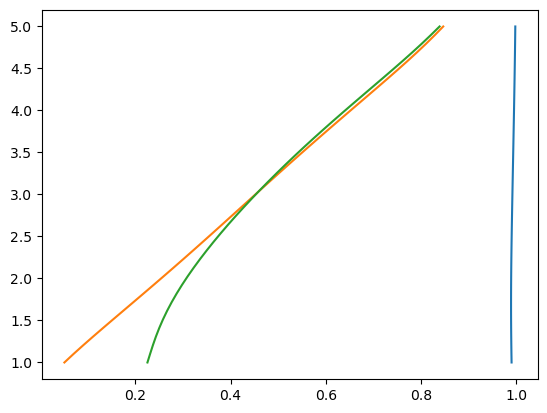

In [7]:
plt.plot(np.split(steady_1[0].y, 3)[0], zg)
plt.plot(np.split(steady_2[0].y, 3)[0], zg)
plt.plot(np.split(unsteady[0].y, 3)[0], zg)

## Decomposition

In [8]:
from steady_state_analysis import compute_eta_decomp, dDelta_dt_from_Delta, inner_product, compute_dDelta_dt_from_range_Delta, generate_contours, build_LDelta

In [9]:
def compute_L_operator(solution, T_k, T1):
    """
    Constructs the matrix representation of L^Delta based on:
        L η = (T_k @ (Δ * η)) - (T1 @ Δ) * η
    using discretized quadrature.
    
    Parameters:
        delta : ndarray, shape (n,)
            Discretized Δ(z)
        T_k   : ndarray, shape (n, n)
            Discretized kernel T^k(z, z')
        T1    : ndarray, shape (n, n)
            Discretized kernel T^1(z, z')
        dz    : float
            Grid spacing in z
            
    Returns:
        L : ndarray, shape (n, n)
            Matrix representation of L^Δ
    """
    delta = np.split(solution.y, 3)[0]
    delta = delta.flatten()
    
    # First term: integral against η — build matrix T_k * Δ * dz
    A = T_k @ np.diag(delta)# shape (n,)

    # Make it into a matrix multiplying η: outer product
    A_matrix = A #np.outer(A, np.ones_like(delta))  # shape (n, n)

    # Second term: scalar coefficient at each row
    B = T1 @ (delta)  # shape (n,)
    B_matrix = np.diag(B)  # shape (n, n)

    # Final operator: L = A_matrix - B_matrix
    L = A_matrix - B_matrix
    return L

def compute_spectra(solution, T_k, T1):
    """
    Computes the eigenvalues and eigenvectors of L^Δ.
    
    Returns:
        eigenvalues : ndarray
        eigenvectors : ndarray (each column is a right eigenvector)
    """
    L = compute_L_operator(solution, T_k*dz, T1*dz)
    eigenvalues, eigenvectors = np.linalg.eig(L)
    return eigenvalues, eigenvectors


In [10]:
eigenvalues, eigenvectors = np.linalg.eig(build_LDelta(np.ones(N), Li * dz, oc * dz))
def project_onto_unperturbed_spectra(solution, eigenvectors):
    delta, eta_real, eta_imag = np.split(solution.y, 3)
    coeffs = eigenvectors.T @ delta
    return coeffs

In [11]:
def compute_spectra_old(solution, Li, oc):
    delta, eta_real, eta_imag = np.split(solution.y, 3)
    eigenvalues, eigenvectors = np.linalg.eig(build_LDelta(delta, Li * dz, oc * dz))
    return eigenvalues, eigenvectors


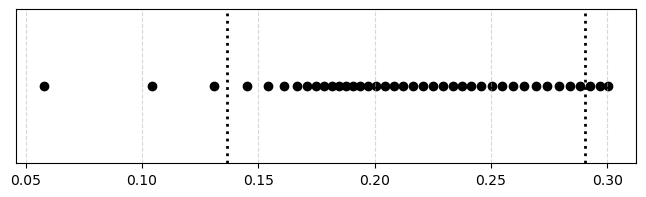

In [12]:
solution = steady_1[0]
# y-values are all zero (on the x-axis)
y_values = np.zeros_like(zg)

# Plot
plt.figure(figsize=(8, 2))
eigenvalues = -compute_spectra(solution, Li, oc)[0]
plt.scatter(eigenvalues, y_values, color='black')  # black dots on x-axis
plt.axvline(x=(np.min(oc @ np.split(solution.y, 3)[0] * dz)-delta_hat), color='black', linestyle=':', linewidth=2) 
plt.axvline(x=(np.max(oc @ np.split(solution.y, 3)[0] * dz)- delta_hat), color='black', linestyle=':', linewidth=2)
plt.yticks([])  # hide y-axis ticks

# Optionally add grid and markers
plt.grid(True, axis='x', linestyle='--', alpha=0.5)

plt.show()

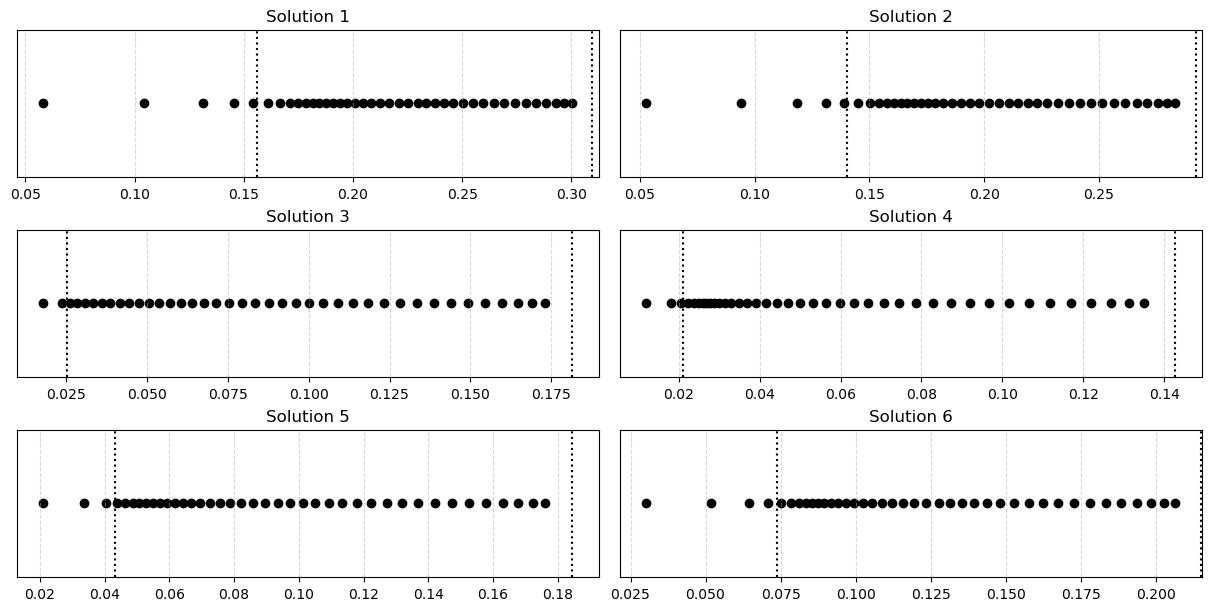

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import math

# Assume: solutions is your list/array of Solution objects
solutions = [steady_1[0], steady_1[-1], steady_2[0], steady_2[-1], unsteady[0], unsteady[-1] ] # or whatever list you're using

# Parameters
num_solutions = len(solutions)
ncols = 2
nrows = math.ceil(num_solutions / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 2 * nrows), constrained_layout=True)

# Flatten axes array for easy indexing
axes = axes.flatten()

for i, solution in enumerate(solutions):
    ax = axes[i]

    # Eigenvalues and y-values
    eigenvalues = -compute_spectra(solution, Li, oc)[0]
    y_values = np.zeros_like(eigenvalues)

    # Plot dots on x-axis
    ax.scatter(eigenvalues, y_values, color='black')

    # Add vertical dotted lines from delta term
    delta = np.split(solution.y, 3)[0]
    oc_delta = oc @ delta * dz
    ax.axvline(x=np.min(oc_delta), color='black', linestyle=':', linewidth=1.5)
    ax.axvline(x=np.max(oc_delta), color='black', linestyle=':', linewidth=1.5)

    # Hide y-axis ticks
    ax.set_yticks([])
    ax.grid(True, axis='x', linestyle='--', alpha=0.5)

    # Optional title
    ax.set_title(f"Solution {i+1}")

# Hide unused subplots if number is odd
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set the threshold for eigenvalue magnitude
midpoint = len(steady_1)//2
solutions = [steady_1[0], steady_1[midpoint], steady_1[-1], steady_2[0], steady_2[midpoint], steady_2[-1], unsteady[0], unsteady[midpoint], unsteady[-1] ]  # List of solutions
num_solutions = len(solutions)

# Layout: 2 columns, enough rows to fit all solutions
ncols = 3
nrows = math.ceil(num_solutions / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 4 * nrows), constrained_layout=True)
axes = axes.flatten()  # Flatten for easy indexing

for i, solution in enumerate(solutions):
    ax = axes[i]

    # --- Compute eigenvalues and eigenvectors ---
    delta = np.split(solution.y, 3)[0]
    oc_delta = oc @ delta * dz
    lam_min = -np.max(oc_delta)
    lam_max = -np.min(oc_delta)

    eigenvalues, eigenvectors = compute_spectra(solution, Li, oc)

    # --- Plot eigenvectors outside [lam_min, lam_max] ---
    mask = (eigenvalues < lam_min) | (eigenvalues > lam_max)
    plotted_any = False
    sum = np.zeros(N)
    for j in np.where(mask)[0]:
        j = np.where(mask)[0][0]
        evector = eigenvectors[:, j].real * -1
        ax.plot(evector, zg, label=f"λ={eigenvalues[j]:.2f}")
        plotted_any = True
        sum+=evector # * eigenvalues[j] 

   # ax.plot(sum, zg, label=f"sum")

    # Titles and aesthetics
    ax.set_title(f"Solution {i+1}\nλ outside [{lam_min:.2f}, {lam_max:.2f}]")
    ax.set_xlabel("Eigenvector value")
    ax.set_ylabel("z")
    ax.grid(True)
    if plotted_any:
        ax.legend(fontsize=7)

# Remove unused subplots (if any)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))
solutions = [steady_1[0], steady_1[midpoint], steady_1[-1], steady_2[0], steady_2[midpoint], steady_2[-1], unsteady[0], unsteady[midpoint], unsteady[-1] ]  # List of solutions

for i, solution in enumerate(solutions):  # Replace with your solution list
    delta = np.split(solution.y, 3)[0]
    oc_delta = oc @ delta * dz
    lam_min = -np.max(oc_delta)
    lam_max = -np.min(oc_delta)

    eigenvalues, eigenvectors = compute_spectra(solution, Li, oc)
    
    # Select eigenvalues outside the continuous range
    discrete_mask = (eigenvalues > lam_min) | (eigenvalues < lam_max)

    if np.any(discrete_mask):
        idx = np.argmax(eigenvalues.real * discrete_mask)  # index of most unstable discrete eigenvalue
        eigval = eigenvalues[idx]
        eigvec = eigenvectors[:, idx].real
        
        plt.plot(eigvec, zg, label=f"Steady {i+1}, λ={eigval:.2f}, idx={idx}")

plt.title("Most Unstable Discrete Eigenmodes")
plt.xlabel("z")
plt.ylabel("Eigenvector value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
plt.plot(compute_spectra(steady_2[-1], Li, oc)[1][:, -3], zg)

In [ ]:
plt.plot(compute_spectra(unsteady[0], Li, oc)[0])
plt.plot(compute_spectra(unsteady[-1], Li, oc)[0])

In [47]:
import numpy as np
from scipy.sparse import bmat, diags

def build_full_jacobian(solution, T_k, T1, dz, gamma, S_k, delta_hat):
    # --- Real and Imag parts ---
    delta, eta_r, eta_i = np.split(solution.y, 3)
    n = len(delta)

    kappa = solution.alpha1

    # --- Build L^Delta ---
    L_real = T_k @ (delta * dz)  # shape (n,)
    L_op = np.outer(L_real, np.ones(n)) - np.diag(T1 @ (delta * dz))
    L = 1j * S_k * L_op - np.eye(n)

    # --- ∂η̇ / ∂η (split into real/imag) ---
    A = L.real
    B = L.imag
    J_eta_eta = np.block([
        [A, -B],
        [B,  A]
    ])

    # --- ∂η̇ / ∂Δ ---
    d_eta_d_delta_r = np.zeros((n, n))
    d_eta_d_delta_i = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            d_eta_d_delta_r[i, j] = S_k * (
                - T1[i, j] * eta_r[i] * dz + T_k[i, j] * eta_r[j] * dz
            )
            d_eta_d_delta_i[i, j] = S_k * (
                - T1[i, j] * eta_i[i] * dz + T_k[i, j] * eta_i[j] * dz
            )
    d_eta_d_delta = np.block([[d_eta_d_delta_r], [d_eta_d_delta_i]])

    # --- ∂Δ̇ / ∂η_r and ∂η_i ---
    d_delta_d_eta_r = diags(-2 * gamma * kappa * delta * eta_r)
    d_delta_d_eta_i = diags(-2 * gamma * kappa * delta * eta_i)
    J_delta_eta = np.hstack([d_delta_d_eta_r.toarray(), d_delta_d_eta_i.toarray()])

    # --- ∂Δ̇ / ∂Δ ---
    J_delta_delta = diags(-gamma * (1 + kappa * (eta_r**2 + eta_i**2)))

    # --- Assemble full Jacobian ---
    J_top = np.hstack([J_eta_eta, d_eta_d_delta])
    J_bot = np.hstack([J_delta_eta, J_delta_delta.toarray()])
    J = np.vstack([J_top, J_bot])

    return J


In [50]:
J = build_full_jacobian(unsteady[0], Li, oc, dz, 1, S_hat, delta_hat)

In [51]:
np.linalg.eig(J)

EigResult(eigenvalues=array([-0.99998942+1708.14565815j, -0.99998942-1708.14565815j,
       -0.9999986  +110.38677743j, -0.9999986  -110.38677743j,
       -0.99999754 +109.26657144j, -0.99999754 -109.26657144j,
       -0.99999507 +108.03582879j, -0.99999507 -108.03582879j,
       -0.99998864 +106.03022781j, -0.99998864 -106.03022781j,
       -0.99998515 +103.06458849j, -0.99998515 -103.06458849j,
       -0.99998138  +99.73832722j, -0.99998138  -99.73832722j,
       -0.99997694  +96.27745953j, -0.99997694  -96.27745953j,
       -0.99997166  +92.79211755j, -0.99997166  -92.79211755j,
       -0.99996538  +89.34398637j, -0.99996538  -89.34398637j,
       -0.99995793  +85.96901983j, -0.99995793  -85.96901983j,
       -0.9999491   +82.68821838j, -0.9999491   -82.68821838j,
       -0.99993868  +79.51348341j, -0.99993868  -79.51348341j,
       -0.99992641  +76.45101765j, -0.99992641  -76.45101765j,
       -0.99991202  +73.50338179j, -0.99991202  -73.50338179j,
       -0.99989522  +70.6707729j 